# k-nearest neighbors (KNN)

Classification of beans in species using KNN vote based on most important features according to the info provided by the optimal random forest, and with imbalanced or balanced (oversampled) data.

In [36]:
# Installing dependencies
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [103]:
# Fetching processed datasets
with open('X_train', 'rb') as file: X_train = pickle.load(file)
with open('y_train', 'rb') as file: y_train = np.ravel(pickle.load(file))
with open('X_test' , 'rb') as file: X_test  = pickle.load(file)
with open('y_test' , 'rb') as file: y_test  = pickle.load(file)
with open('best_rf_clf.pkl', 'rb') as file: best_rf_clf = pickle.load(file)

In [6]:
# Sorting features by importance provided by the optimal random forest
features_dict = dict(enumerate(best_rf_clf.feature_importances_))
features_list = sorted(features_dict.items(), key = lambda item: item[1], reverse = True)
features_list

[(2, 0.3142879027641842),
 (3, 0.1648580501373519),
 (12, 0.13808776116926594),
 (14, 0.08173824405512492),
 (11, 0.08022147851974754),
 (1, 0.05958046565876466),
 (10, 0.047421763420313255),
 (15, 0.02583965423737132),
 (6, 0.01612903611346848),
 (7, 0.015260908597228853),
 (0, 0.014314709326667466),
 (9, 0.012900469224532364),
 (8, 0.00849707138253093),
 (13, 0.008284226719571824),
 (4, 0.007139114650114524),
 (5, 0.00543914402376185)]

### k-nearest neighbors with imbalanced classes

In [47]:
# Defining the hyperparameter distribution for random search
param_dict = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']}

In [48]:
# Setting the random search

def calculate_metrics(y_test, y_pred):
    """Calculating scoring metrics"""
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    return [precision, recall, f1, accuracy]

knn_clf = KNeighborsClassifier(random_state=42)
random_search = RandomizedSearchCV(knn_clf, param_distributions=param_dict, n_iter=100, cv=5, scoring='f1_weighted', random_state=42, n_jobs = -1)
features_train = []
results_df1 = pd.DataFrame(columns = ['metric', 'n_neighbors', 'weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list: # Feeding new features by importance in each interation
        
        # Optimizing the hyperparameters
        features_train.append(feature_index)
        X_train_temp = X_train.iloc[:,features_train]
        random_search.fit(X_train_temp, y_train)
        results_df1.loc[len(features_train)] = random_search.best_params_
    
        # Evaluating the model
        best_clf = random_search.best_estimator_
        y_pred = best_clf.predict(X_test.iloc[:,features_train])
        feature = X_train.columns[feature_index]
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred) + [feature]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

,metric,n_neighbors,weights,Precision,Recall,F1 score,Accuracy,Feature added
1,minkowski,15,uniform,0.5397,0.5767,0.5438,0.5767,MajorAxisLength
2,minkowski,15,uniform,0.8774,0.8774,0.8769,0.8774,MinorAxisLength
3,minkowski,15,uniform,0.8774,0.8774,0.8769,0.8774,ShapeFactor1
4,minkowski,15,uniform,0.8774,0.8774,0.8769,0.8774,ShapeFactor3
5,manhattan,16,uniform,0.8776,0.8777,0.8772,0.8777,Compactness
6,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,Perimeter
7,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,Roundness
8,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,ShapeFactor4
9,manhattan,4,distance,0.8454,0.8417,0.8403,0.8417,ConvexArea
10,manhattan,4,distance,0.8452,0.8417,0.8404,0.8417,EquivDiameter


Without doubt, best hyperparameters are {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski'}. Additionally, notice that using the first six most important features, the model obtain its maximum metric scores. Later it suffers from overfitting / sensivity to high-dimensional data. 'MajorAxisLength' is withouth doubt an important feature as provides the model the capacity to achieve high metric scores for just one feature. Same for 'MinorAxisLength' when combined with the previous one. However, notice that 'ShapeFactor1' and 'ShapeFactor3' do not alter the metrics: they are not informative and we may test the model performance when getting rid of them. On the other hand, 'Compactness' and 'Perimeter' slightly improve the scores to their maximum, so one of them may not be necessary.

In [85]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'Compactness', and 'Perimeter' features
results_df1 = pd.DataFrame(columns = ['metric', 'n_neighbors', 'weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_selected = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter']
feature_extra = None

for i in range(1,3):

    # Optimizing the hyperparameters
    X_train_temp = X_train.loc[:,features_selected]
    random_search.fit(X_train_temp, y_train)
    results_df1.loc[i] = random_search.best_params_
    
    # Evaluating the model
    best_clf = random_search.best_estimator_
    y_pred = best_clf.predict(X_test.loc[:,features_selected])
    results_df2.loc[i] = calculate_metrics(y_test, y_pred) + [feature_extra]
    
    results_df = pd.concat([results_df1, results_df2], axis = 1)
    feature_extra = 'Compactness'
    features_selected += [feature_extra]

results_df

,metric,n_neighbors,weights,Precision,Recall,F1 score,Accuracy,Feature extra
1,minkowski,9,distance,0.9059,0.905,0.9052,0.905,NaN
2,minkowski,9,distance,0.9059,0.905,0.9052,0.905,Compactness


Removing the 'ShapeFactor1' 'ShapeFactor3', and 'Compactness' features (non-informative) do not compromise the predictive scores while enhancing the computational efficiency. This simple model with new hyperparameters is robust just using three features, 'MajorAxisLength', 'MajorAxisLength', and 'Perimeter', which also share a high correlation (redundant), but the model succeed in capturing and modelling non-linear relationships.

In [87]:
# Evaluating the optimal model by classes

def calculate_metrics_classes(y_test, y_pred):
    """Calculating scoring metrics by class"""
    results_df_class = pd.DataFrame(columns = sorted(set(y_test['Class'])))
    results_df_class.loc['Precision'] = np.around(precision_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['Recall'] = np.around(recall_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['F1 score'] = np.around(f1_score(y_test, y_pred, average=None), decimals = 4)
    return results_df_class

X_train_temp = X_train.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Perimeter']]
random_search.fit(X_train_temp, y_train)
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Perimeter']])
results_df_class = calculate_metrics_classes(y_test, y_pred)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9208,1.0,0.8898,0.9001,0.9590,0.9370,0.8360
Recall,0.8510,1.0,0.9387,0.9136,0.9295,0.9142,0.8570
F1 score,0.8845,1.0,0.9136,0.9068,0.9440,0.9255,0.8463


### k-nearest neighbors with balanced classes

In [51]:
# Defining the hyperparameter distribution for random search
param_dict = {
    'knn__n_neighbors': randint(1, 20),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']}

In [65]:
# After oversampling the training data with SMOTE, AGAIN finding and evaluating the optimal model
knn_clf = KNeighborsClassifier(random_state=42)
smote = SMOTE(random_state=42)
pipeline = Pipeline([("smote", SMOTE()), ("knn", knn_clf)])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_balanced = RandomizedSearchCV(pipeline, param_distributions=param_dict, n_iter=100, cv=kf, scoring='f1_weighted', random_state=42, n_jobs = -1)

features_train = []
results_df1 = pd.DataFrame(columns = ['knn__metric', 'knn__n_neighbors', 'knn__weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list:
        
        # Optimizing the hyperparameters
        features_train.append(feature_index)
        X_train_temp = X_train.iloc[:,features_train]
        random_search_balanced.fit(X_train_temp, y_train)
        results_df1.loc[len(features_train)] = random_search_balanced.best_params_
    
        # Evaluating the model
        best_clf_balanced = random_search_balanced.best_estimator_
        y_pred_balanced = best_clf_balanced.predict(X_test.iloc[:,features_train])
        feature = X_train.columns[feature_index]
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred_balanced) + [feature]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

,knn__metric,knn__n_neighbors,knn__weights,Precision,Recall,F1 score,Accuracy,Feature added
1,minkowski,17,uniform,0.5446,0.5368,0.5376,0.5368,MajorAxisLength
2,euclidean,18,uniform,0.8710,0.8703,0.8706,0.8703,MinorAxisLength
3,manhattan,16,uniform,0.8659,0.8641,0.8647,0.8641,ShapeFactor1
4,euclidean,19,uniform,0.8697,0.8683,0.8689,0.8683,ShapeFactor3
5,manhattan,16,uniform,0.8668,0.8651,0.8657,0.8651,Compactness
6,euclidean,19,uniform,0.9086,0.9075,0.9077,0.9075,Perimeter
7,minkowski,17,distance,0.9110,0.9092,0.9096,0.9092,Roundness
8,minkowski,19,distance,0.9077,0.9060,0.9064,0.9060,ShapeFactor4
9,manhattan,5,distance,0.8455,0.8435,0.8434,0.8435,ConvexArea
10,manhattan,4,distance,0.8490,0.8476,0.8473,0.8476,EquivDiameter


Results are almost in line with the conclusion of the previous ones, but 'Roundness' feature joins the party. We will check again if the model is still robust when removing 'ShapeFactor1', 'ShapeFactor3' and 'Compactness' features.

In [101]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', and 'Roundness' features
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_selected = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'Roundness']
feature_extra = None
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors=17, weights='distance', random_state=42)

for i in range(1,3):

    # Optimizing the hyperparameters
    X_train_temp = X_train_balanced.loc[:,features_selected]
    knn_clf.fit(X_train_temp, y_train_balanced)
    
    # Evaluating the model
    y_pred_balanced = knn_clf.predict(X_test.loc[:,features_selected])
    results_df2.loc[i] = calculate_metrics(y_test, y_pred_balanced) + [feature_extra]
    
    feature_extra = 'Compactness'
    features_selected += [feature_extra]

results_df2

,Precision,Recall,F1 score,Accuracy,Feature extra
1,0.9119,0.9104,0.9108,0.9104,NaN
2,0.9119,0.9104,0.9108,0.9104,Compactness


Similar to the model trained with imbalanced data, but in this case the predictive scores improve, 'Roundness' feature is incorporated, and hyperparameters are different.

In [99]:
# Evaluating the optimal model by classes
X_train_temp = X_train_balanced.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'Roundness']]
knn_clf.fit(X_train_temp, y_train_balanced)
y_pred_balanced = knn_clf.predict(X_test.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'Roundness']])
results_df_class = calculate_metrics_classes(y_test, y_pred_balanced)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9043,0.9938,0.8860,0.9374,0.9572,0.9319,0.8337
Recall,0.8586,1.0000,0.9366,0.8995,0.9313,0.9304,0.8871
F1 score,0.8808,0.9969,0.9106,0.9181,0.9441,0.9312,0.8596


There was no misclassification of Bombay beans till now, which is a symptom of overfitting as Bombay class is the one with least samples, so the hardly oversampled training set starts to not be representative of the test set.

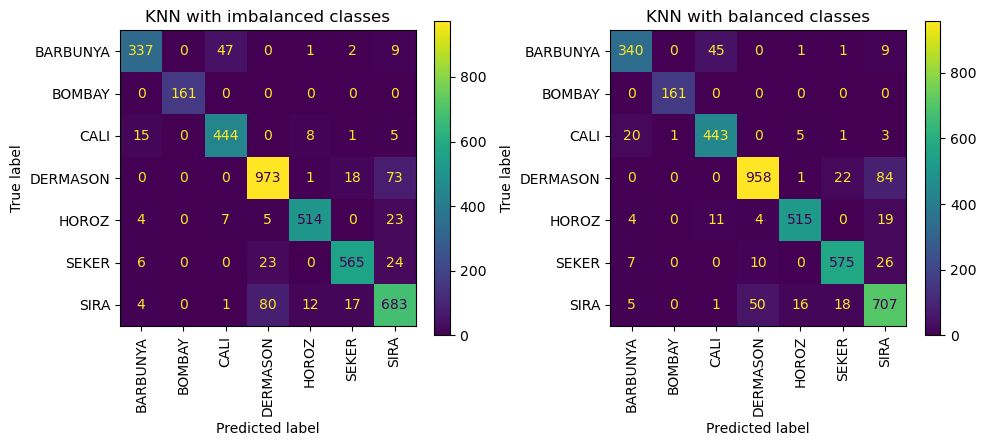

In [100]:
# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 16))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[0], colorbar = False)
axes[0].set_title('KNN with imbalanced classes')
axes[0].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[0], shrink=0.2)

cm = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[1], colorbar = False)
axes[1].set_title('KNN with balanced classes')
axes[1].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[1], shrink=0.2)

plt.tight_layout()
plt.show()

In [102]:
# Saving optimal k-neighbors classifier
with open('best_knn_clf.pkl', 'wb') as file:
    pickle.dump(knn_clf, file)